In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_PANDA = False
CONNECT_MOBILE = False

IP_CUR = "192.168.17.4"# get_ip_address()
MOBILE_IP = "192.168.0.102"
PANDA_HOST_IP = "192.168.17.2"
PANDA_ROBOT_IP = "192.168.17.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

from concurrent import futures
import logging
import math
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

import grpc
import RemoteCam_pb2
import RemoteCam_pb2_grpc

MAX_MESSAGE_LENGTH = 10000000
PORT_CAM = 10509

Current PC IP: 192.168.17.4
Mobile ROB IP: 192.168.0.102


In [2]:
PANDA_BASE_OFFSET = (0.172,0,0.439)
PANDA_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.6
COL_COLOR = (1,1,1,0.2)
CARRIER_DIM = (0.4, 0.29, 0.635)
CLOCK_DIM = (0.138, 0.05, 0.078)
TABLE_DIM = (1.6, 0.8, 0.725)
    
# if EXP_SCENARIO == ExpType.REMOVE_OBS: ## Obstacle removing
#     BAG_COUNT = 5
#     CLOCK_COUNT = 0
#     TARGET_COUNT = 5
#     LOG_FORCE = False
# else: ## Contact 
#     BAG_COUNT = 3
#     CLOCK_COUNT = 3
#     TARGET_COUNT = 5
#     LOG_FORCE = True

from pkg.controller.combined_robot import *
from pkg.project_config import *


if not CONNECT_PANDA:
    indy_7dof_client.kiro_tool.OFFLINE_MODE = True
kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR))
robot_config = RobotConfig(1, RobotType.panda, 
                           (PANDA_BASE_OFFSET, PANDA_BASE_RPY),
                           "{}/{}".format(PANDA_HOST_IP, PANDA_ROBOT_IP), root_on="kmb0_platform")

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[CONNECT_MOBILE, CONNECT_PANDA])

connection command:
kmb0: False
panda1: False


In [3]:
from util import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene
from pkg.geometry.geometry import GeometryItem
from pkg.geometry.geotype import GEOTYPE

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

gscene.set_workspace_boundary(
    -1, 4, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

viewpoint = add_cam(gscene, tool_link="panda1_link8")
gscene.show_pose(crob.get_real_robot_pose())

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [4]:
# Q_CUR = crob.get_real_robot_pose()[6:] + [0.1] *7
# Q_LOC = list(Q_CUR[:6])
# Q_NEW = np.array(Q_LOC + list(Q_CUR))
# crob.joint_move_make_sure(Q_NEW)

### MultiICP detector

In [19]:
from pkg.detector.multiICP.multiICP import MultiICP, MultiICP_Obj
from pkg.detector.multiICP.config import *
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

import open3d as o3d
import numpy as np

CONNECT_CAM = False
REMOTE_CAM = False

In [20]:
# realsense = RealSense()

# from demo_utils.data_reconstructed_camera import DataRecontructedCamera
# dcam = DataRecontructedCamera(crob, viewpoint)
# if not CONNECT_CAM:
#     dcam.initialize()
    
if CONNECT_CAM:
    realsense = RealSense()
    micp = MultiICP(realsense)
    micp.initialize()
#     dcam.ready_saving(*realsense.get_config())
#     cam_pose = viewpoint.get_tf(VIEW_POSE_EXT)
else:
    if REMOTE_CAM:
        # use remote camera
        micp = MultiICP(None)
        micp.initialize(remote_cam=REMOTE_CAM)
    else:
        # use manually given camera configs
        micp = MultiICP(None)
#         cam_mtx = np.array([[639.782, 0, 635.894],
#                                         [0, 638.492, 359.51],
#                                         [0, 0, 1]])
#         distcoeffs = np.array([-0.0534753, -0.0592427, 2.97771e-5, -0.000914619, -0.0184789])
#         depth_scale = 0.001
#         config_list = [cam_mtx, distcoeffs, depth_scale]
#         img_dim = (720, 1280)
        config_list, img_dim = load_pickle(RNB_PLANNING_DIR+"release/multiICP_data/cam_configs.pkl")
        micp.initialize(config_list, img_dim)
#         micp = MultiICP(dcam)
#         micp.initialize()

Camera is not set - skip initialization, use manually given camera configs


### Shared Detector

In [7]:
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")

from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(tuple(reversed(micp.dsize))+(3,))()
sd.init()

### set ICP config

In [8]:
# Load config file of object information
obj_info_dict = get_obj_info()

In [78]:
# initial guess는 실험하는거 보면서 수정?
micp_suitcase = MultiICP_Obj(obj_info_dict["suitcase"], None,
                        OffsetOnModelCoord("suitcase", R=np.matmul(Rot_axis(1, np.pi/2), Rot_axis(3, np.pi/2)), offset=(0.,0.,0.14)))


micp_clock = MultiICP_Obj(obj_info_dict["clock"], None,
                        OffsetOnModelCoord("clock", R=Rot_axis(1, np.pi/2), offset=(-0.07,0.03,0.)))


micp_table = MultiICP_Obj(obj_info_dict["dining table"], None,
                        OffsetOnModelCoord("dining table", R=Rot_axis(1, 3*np.pi/4), offset=(0.,0.35,0.6)))

In [79]:
micp_dict = {"suitcase": micp_suitcase, "clock": micp_clock, "dining table": micp_table}
# micp_dict = {"clock": micp_clock}
# micp_dict = {"dining table": micp_table}
# micp_dict = {"suitcase": micp_suitcase}

In [80]:
# set config information for micp
micp.set_config(micp_dict, sd, crob, viewpoint)

In [82]:
color_img = cv2.imread("./test_img/color/0021.png", flags=cv2.IMREAD_UNCHANGED)
mask_out_list = micp.inference(color_img)
np.max(mask_out_list[60])

3

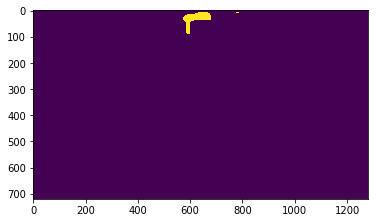

In [85]:
mask_zero = np.empty((720, 1280), dtype=bool)
mask_zero[:,:] = False
mask_zero[np.where(mask_out_list[60] == 3)] = True
plt.imshow(mask_zero)

### Detect

In [34]:
# for clock
micp.set_ICP_thres(thres_ICP=0.09, thres_front_ICP=0.03)
micp.set_multiobject_num(num=3)
pose_dict = micp.detect(name_mask=["clock"], visualize=True)

name_mask is ['clock']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 3
===== Detected : clock, 4 object(s) =====

'clock' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.195425e-02, and correspondence_set size of 693
Access transformation to get result.
Transformation is:
[[ 0.98064841 -0.14244078 -0.13431051 -0.14558757]
 [-0.17044213 -0.28362229 -0.94366725  0.01912652]
 [ 0.09632325  0.94829796 -0.30241166  1.15243266]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.98064841 -0.14244078 -0.13431051 -0.14558757]
 [-0.17044213 -0.28362229 -0.94366725  0.01912652]
 [ 0.09632325  0.94829796 -0.30241166  1.15243266]
 [ 0.          0.          0.          1.        ]]
initial: 
[[ 0.98 -0.14 -0.13 -0.15]
 [-0.17 -0.28 -0.94  0.02]
 [ 0.1   0.95 -0.3   1.15]
 [ 0.    0.    0.  

In [16]:
# for suitcase
micp.set_ICP_thres(thres_ICP=0.17, thres_front_ICP=0.05)
micp.set_multiobject_num(num=2)
pose_dict = micp.detect(name_mask=["suitcase"], visualize=True)

name_mask is ['suitcase']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 2
===== Detected : suitcase, 2 object(s) =====

'suitcase' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.756227e-01, inlier_rmse=7.673662e-02, and correspondence_set size of 3682
Access transformation to get result.
Transformation is:
[[-0.93474121 -0.29554393 -0.19726289  0.32464131]
 [ 0.07717803  0.37303473 -0.92460188  0.25438519]
 [ 0.34684639 -0.87948785 -0.32588144  2.22035377]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[-0.93474121 -0.29554393 -0.19726289  0.32464131]
 [ 0.07717803  0.37303473 -0.92460188  0.25438519]
 [ 0.34684639 -0.87948785 -0.32588144  2.22035377]
 [ 0.          0.          0.          1.        ]]
initial: 
[[-0.93 -0.3  -0.2   0.32]
 [ 0.08  0.37 -0.92  0.25]
 [ 0.35 -0.88 -0.33  2.22]
 [ 0.    

In [90]:
# for dining table
micp.set_ICP_thres(thres_ICP=0.8, thres_front_ICP=0.15)
# micp.set_multiobject_num(num = 1)
micp.set_merge_mask(merge=True)
color_img = cv2.imread("./test_img/color/0022.png", flags=cv2.IMREAD_UNCHANGED)
depth_img = cv2.imread("./test_img/depth/0022.png", flags=cv2.IMREAD_UNCHANGED)
Q = crob.get_real_robot_pose()
micp.cache_sensor(color_img, depth_img, Q)
pose_dict = micp.detect(name_mask=["dining table"], visualize=True)

name_mask is ['dining table']
Maximun num of object for detection : 1
===== Detected : dining table, 3 object(s) =====
[NOTICE] You choose merge option for mask. Detected masks would be merged.

'dining table' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.277007e-01, and correspondence_set size of 7427
Access transformation to get result.
Transformation is:
[[ 0.99207964 -0.10943726 -0.06165603 -0.11160695]
 [-0.12321966 -0.7525802  -0.64686933  0.0846871 ]
 [ 0.0243905   0.64934313 -0.76010432  2.43868537]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.99207964 -0.10943726 -0.06165603 -0.11160695]
 [-0.12321966 -0.7525802  -0.64686933  0.0846871 ]
 [ 0.0243905   0.64934313 -0.76010432  2.43868537]
 [ 0.          0.          0.          1.        ]]
initial: 
[[ 0.99 -0.11 -0.06 -0.11]
 [-0.12 -0.75 -0.65  0.08]
 [ 0.02  0.65 -0.76  2.44]
 [ 

In [111]:
#pose_dict = micp.detect(name_mask=["suitcase", "clock", "dining table"])

### Update Object to scene

In [32]:
center = (.8,0,0)
rpy = (0,0,-np.pi/2)

In [33]:
# add table
# center, rpy = pose_refine("dining table", pose_dict["dining table_1"])
table_vis = add_table(gscene, "table", center, rpy)

In [13]:
# add or update suitcase
add_update_object(gscene, crob, "suitcase", pose_dict, height = CARRIER_DIM[2]/2)

Total 0 suitcase in the scene
Add new suitcase in the scene
Add new suitcase in the scene


In [32]:
# add or update clock
add_update_object(gscene, crob, "clock", pose_dict, separate_dist=0.2, height = TABLE_DIM[2]+CLOCK_DIM[2]/2)

Total 0 clock in the scene
Add new clock in the scene
Add new clock in the scene
Add new clock in the scene


In [35]:
VIEW_CUR = crob.get_real_robot_pose()

Tbc = viewpoint.get_tf(VIEW_CUR)

Tbt = gscene.NAME_DICT["table"].get_tf(VIEW_CUR)

table_dim = np.linalg.norm(TABLE_DIM)

x_z_ratio = np.tan(micp.h_fov_hf)
dist = (table_dim/2) / x_z_ratio * 1

angle_ref = 20

angle_view = angle_ref #+ np.random.uniform(-10, 10)
dist_view = dist #+ np.random.uniform(-1, 1)*bed_dist/4
Tbs = gscene.NAME_DICT["table"].get_tf(VIEW_CUR)
Tbs = np.matmul(Tbs, 
                SE3(np.identity(3), (-TABLE_DIM[0]/2, 0,0)))
Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                SE3(np.identity(3), (-dist_view, 0,0)))
Tbc = np.matmul(Tbs, Tsc)
Tmc = viewpoint.get_tf(VIEW_CUR, from_link=MOBILE_BASE)
Tmc[:3,:3] = np.identity(3)
Tbm = np.matmul(Tbc, SE3_inv(Tmc))
full_view_ext = np.copy(VIEW_POSE_EXT)
full_view_ext[:2] = Tbm[:2,3]
full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)

### Test code for multiple instance detection
* MultiICP Detector 이전까지 실행시키고 아래의 코드 실행
* Separte distance는 수동으로 조절

In [5]:
# Origianlly, 4 suitcases are existed in scene
c10 = add_carrier(gscene, "suitcase_0", (1.,1.,0), (0,0,0))
c11 = add_carrier(gscene, "suitcase_1", (1.,2.,0), (0,0,0))
c12 = add_carrier(gscene, "suitcase_2", (2.,1.,0), (0,0,0))
c13 = add_carrier(gscene, "suitcase_3", (2.,2.,0), (0,0,0))

In [6]:
# Detection result, but T1, T2 are already detected objects so, these are in the scene
# T3 is newly detected object so this is not in the scene
# Therefore, 1 and 2 should be updated, but 3 should be added

T1 = SE3(Rot_axis(3, np.pi/10), (1.1,1.18,0.3))
T2 = SE3(np.identity(3), (2.1,1.88,-0.1))
T3 = SE3(Rot_axis(1, -np.pi/5) , (3.1,1.9,-0.2))
pose_dict = {"suitcase_0":T1, "suitcase_1":T2, "suitcase_2":T3}

In [7]:
add_update_object(gscene, crob, "suitcase", pose_dict)

Total 4 suitcase in the scene
Update existing suitcase in the scene
Update existing suitcase in the scene
Add new suitcase in the scene
